In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

In [2]:
# ============================================================
# 1. Data exploration
# ============================================================
# load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Basic info
print("-"*30, "Basic info", "-"*30)
print(f"train data size: {train_df.shape}")
print(f"test data size: {test_df.shape}")

# data type
print("-"*30, "data type", "-"*30)
print(train_df.dtypes)

print("-"*30, "null cols", "-"*30)
print(train_df.isnull().sum())

print("-"*30, "data description", "-"*30)
print(train_df.describe())

print("-"*30, "depulicate row", "-"*30)
print("depulicate row: ", train_df.duplicated().sum())

# Check data
print("-"*30, "data", "-"*30)
print(train_df.head())

print("-"*30, "is_fraud cols stat", "-"*30)
print(train_df['is_fraud'].value_counts())

print("train_df", train_df.columns)
print("test_df", test_df.columns)

------------------------------ Basic info ------------------------------
train data size: (1000000, 22)
test data size: (300000, 22)
------------------------------ data type ------------------------------
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object
------------------------------ null cols --------------

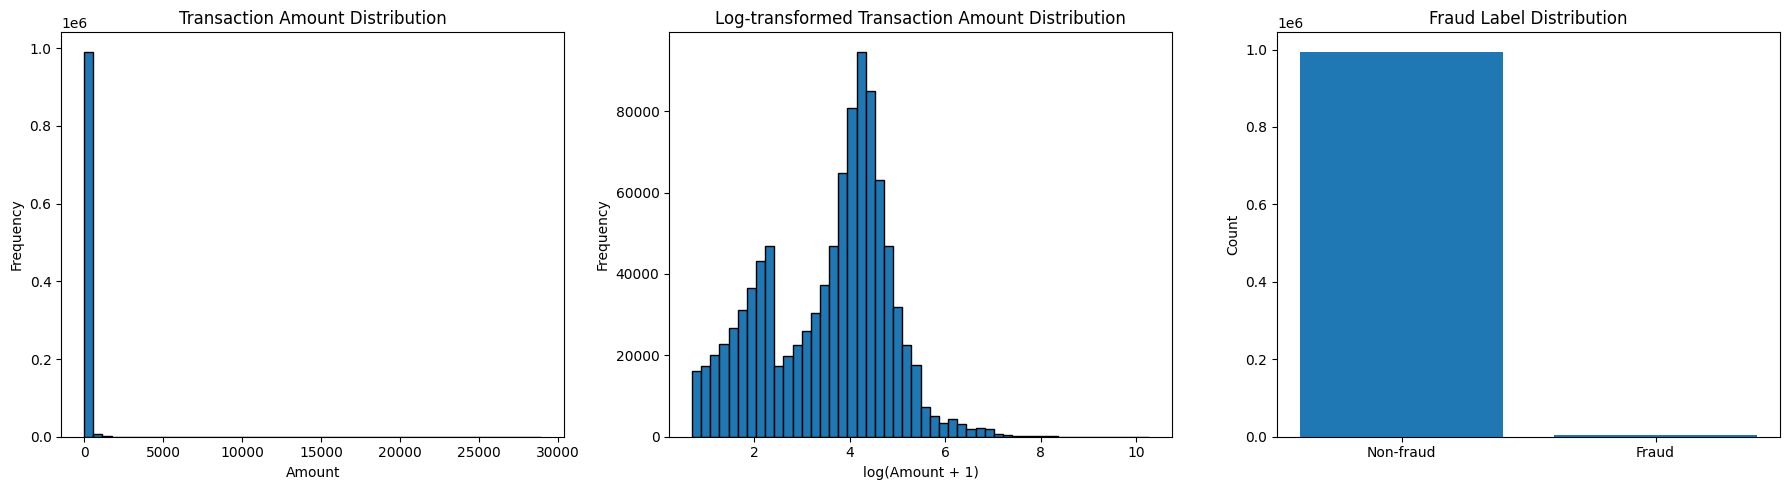

In [3]:
# ============================================================
# 2. Data visualization
# ============================================================

# Visualise target variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Transaction amount distribution
axes[0].hist(train_df['amt'], bins=50, edgecolor='black')
axes[0].set_title('Transaction Amount Distribution')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')

# Log-transformed transaction amount distribution (to reduce skewness)
axes[1].hist(np.log1p(train_df['amt']), bins=50, edgecolor='black')
axes[1].set_title('Log-transformed Transaction Amount Distribution')
axes[1].set_xlabel('log(Amount + 1)')
axes[1].set_ylabel('Frequency')

# Fraud label distribution
fraud_counts = train_df['is_fraud'].value_counts()
axes[2].bar(['Non-fraud', 'Fraud'], fraud_counts.values)
axes[2].set_title('Fraud Label Distribution')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [4]:
# ============================================================
# 3. Feature engineering exploration
# ============================================================

# Categorical features: category, gender, state, job, city
# Time-related: trans_date_trans_time, dob, unix_time

def add_advanced_features(df_clean):
    """Add advanced engineered features."""
    
    # 1. More fine-grained time features (cyclical encoding)
    df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['trans_hour'] / 24)
    df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['trans_hour'] / 24)
    df_clean['day_sin'] = np.sin(2 * np.pi * df_clean['trans_day'] / 31)
    df_clean['day_cos'] = np.cos(2 * np.pi * df_clean['trans_day'] / 31)
    
    # 2. Interaction features
    df_clean['weekend_hour'] = df_clean['is_weekend'] * df_clean['trans_hour']
    df_clean['night_weekend'] = df_clean['is_night'] * df_clean['is_weekend']
    
    # 3. Distance & location interactions
    df_clean['lat_long_interaction'] = df_clean['lat'] * df_clean['long']
    df_clean['distance_pop_ratio'] = df_clean['customer_merchant_distance_km'] / (df_clean['city_pop'] + 1)
    
    return df_clean

# Data cleaning
def clean_and_prepare_data(df):
    """Feature engineering and preprocessing."""
    df_clean = df.copy()

    # 1. Convert datetime columns
    df_clean['trans_date_trans_time'] = pd.to_datetime(df_clean['trans_date_trans_time'])
    df_clean['dob'] = pd.to_datetime(df_clean['dob'])

    # 2. Age feature
    df_clean['age'] = (df_clean['trans_date_trans_time'] - df_clean['dob']).dt.days / 365.25

    # 3. Time-based features
    df_clean['trans_hour'] = df_clean['trans_date_trans_time'].dt.hour
    df_clean['trans_dayofweek'] = df_clean['trans_date_trans_time'].dt.dayofweek
    df_clean['trans_month'] = df_clean['trans_date_trans_time'].dt.month
    df_clean['trans_day'] = df_clean['trans_date_trans_time'].dt.day
    df_clean['trans_quarter'] = df_clean['trans_date_trans_time'].dt.quarter
    df_clean['trans_year'] = df_clean['trans_date_trans_time'].dt.year
    df_clean['is_weekend'] = (df_clean['trans_dayofweek'] >= 5).astype(int)
    
    df_clean['is_night'] = ((df_clean['trans_hour'] >= 22) | 
                            (df_clean['trans_hour'] <= 6)).astype(int)
    df_clean['is_business_hours'] = ((df_clean['trans_hour'] >= 9) & 
                                      (df_clean['trans_hour'] <= 17)).astype(int)
    df_clean['is_rush_hour'] = (((df_clean['trans_hour'] >= 7) & (df_clean['trans_hour'] <= 9)) |
                                  ((df_clean['trans_hour'] >= 17) & (df_clean['trans_hour'] <= 19))).astype(int)
    
    # 4. Geo-distance feature
    def haversine_np(lat1, lon1, lat2, lon2):
        R = 6371.0
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    df_clean['customer_merchant_distance_km'] = haversine_np(
        df_clean['lat'], df_clean['long'], df_clean['merch_lat'], df_clean['merch_long']
    )
  
    # Distance features
    df_clean['distance_log'] = np.log1p(df_clean['customer_merchant_distance_km'])
    df_clean['distance_squared'] = df_clean['customer_merchant_distance_km'] ** 2
    df_clean['is_local_transaction'] = (df_clean['customer_merchant_distance_km'] < 10).astype(int)
    df_clean['is_very_far'] = (df_clean['customer_merchant_distance_km'] > 200).astype(int)
    df_clean['is_medium_distance'] = ((df_clean['customer_merchant_distance_km'] >= 10) & 
                                       (df_clean['customer_merchant_distance_km'] <= 200)).astype(int)
    
    # Population features
    df_clean['city_pop_log'] = np.log1p(df_clean['city_pop'])
    df_clean['city_pop_sqrt'] = np.sqrt(df_clean['city_pop'])
    df_clean['is_big_city'] = (df_clean['city_pop'] > 100000).astype(int)
    df_clean['is_small_town'] = (df_clean['city_pop'] < 5000).astype(int)
    df_clean['is_medium_city'] = ((df_clean['city_pop'] >= 5000) & 
                                   (df_clean['city_pop'] <= 100000)).astype(int)
    
     # Amount-based features
    if 'amt' in df_clean.columns:
        df_clean['amt_log'] = np.log1p(df_clean['amt'])
        df_clean['amt_sqrt'] = np.sqrt(df_clean['amt'])
        df_clean['amt_squared'] = df_clean['amt'] ** 2
        df_clean['is_high_amt'] = (df_clean['amt'] > 500).astype(int)
        df_clean['is_very_high_amt'] = (df_clean['amt'] > 1000).astype(int)
        df_clean['is_low_amt'] = (df_clean['amt'] < 10).astype(int)
        df_clean['is_medium_amt'] = ((df_clean['amt'] >= 10) & 
                                      (df_clean['amt'] <= 500)).astype(int)
    # Interaction features
        df_clean['distance_amt_interaction'] = df_clean['customer_merchant_distance_km'] * df_clean['amt']
        df_clean['distance_amt_ratio'] = df_clean['customer_merchant_distance_km'] / (df_clean['amt'] + 1)
        df_clean['age_amt_interaction'] = df_clean['age'] * df_clean['amt']
        df_clean['hour_amt_interaction'] = df_clean['trans_hour'] * df_clean['amt']
        df_clean['city_pop_amt_ratio'] = df_clean['city_pop'] / (df_clean['amt'] + 1)
    
    # Age-related features
    df_clean['age_squared'] = df_clean['age'] ** 2
    df_clean['is_young'] = (df_clean['age'] < 30).astype(int)
    df_clean['is_senior'] = (df_clean['age'] > 60).astype(int)
    df_clean['is_middle_age'] = ((df_clean['age'] >= 30) & 
                                  (df_clean['age'] <= 60)).astype(int)
    
    # Combined features
    df_clean['night_far_transaction'] = df_clean['is_night'] * df_clean['is_very_far']
    df_clean['weekend_high_amt'] = df_clean['is_weekend'] * df_clean.get('is_high_amt', 0)

    # Drop raw identifier / redundant columns
    drop_cols = [
        'trans_date_trans_time', 'dob', 'unix_time',
        'cc_num', 'first', 'last', 'street',
    ]
    df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns], inplace=True)

    # Cast categorical columns
    cat_cols = ['category', 'gender', 'state', 'job', 'merchant', 'city']
    for col in cat_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype('category')

    # Add advanced features
    df_clean = add_advanced_features(df_clean)
    return df_clean
# ============================================================
# 4. Apply data cleaning & feature engineering
# ============================================================
train_clean = clean_and_prepare_data(train_df)
test_clean = clean_and_prepare_data(test_df)
print(train_clean.describe())
print("="*60)
print(train_clean.head())


                  amt             zip             lat           long  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.00000   
mean        70.223098    48816.245613       38.538196      -90.22520   
std        166.281811    26850.413687        5.071274       13.73028   
min          1.000000     1257.000000       20.027100     -165.67230   
25%          9.640000    26292.000000       34.668900      -96.79800   
50%         47.430000    48174.000000       39.354300      -87.47690   
75%         83.110000    72011.000000       41.894800      -80.17520   
max      28948.900000    99921.000000       66.693300      -67.95030   

           city_pop       merch_lat      merch_long        is_fraud  \
count  1.000000e+06  1000000.000000  1000000.000000  1000000.000000   
mean   8.823559e+04       38.538365      -90.224964        0.005220   
std    3.002769e+05        5.104406       13.742489        0.072061   
min    2.300000e+01       19.027422     -166.671242        0.000000

In [5]:
# ============================================================
# 5. Define feature encoding function
# ============================================================

from sklearn.preprocessing import LabelEncoder

CATEGORICAL_COLS = ['category', 'gender', 'state', 'job', 'merchant', 'city']

def encode_features(df, is_train=True, encoders=None):
    df_encoded = df.copy()

    if is_train:
        encoders = {}
        for col in CATEGORICAL_COLS:
            if col in df_encoded.columns:
                le = LabelEncoder()
                # Convert to string to avoid dtype inconsistencies
                values = df_encoded[col].astype(str)
                df_encoded[f'{col}_encoded'] = le.fit_transform(values)
                encoders[col] = le

        df_encoded.drop(columns=CATEGORICAL_COLS, errors='ignore', inplace=True)
        return df_encoded, encoders

    else:
        if encoders is None:
            raise ValueError("When is_train=False, encoders must be provided.")

        for col in CATEGORICAL_COLS:
            if col in df_encoded.columns and col in encoders:
                le = encoders[col]
                # Build a mapping from category to encoded value
                mapping = {str(cls): idx for idx, cls in enumerate(le.classes_)}
                # Vectorized mapping; unseen categories are set to -1
                df_encoded[f'{col}_encoded'] = (
                    df_encoded[col]
                    .astype(str)
                    .map(mapping)
                    .fillna(-1)
                    .astype(int)
                )

        df_encoded.drop(columns=CATEGORICAL_COLS, errors='ignore', inplace=True)
        return df_encoded, encoders
    
# ============================================================
# 6. Apply feature encoding
# ============================================================
train_encoded, encoders = encode_features(train_clean, is_train=True)
test_encoded, _ = encode_features(test_clean, is_train=False, encoders=encoders)
print(train_encoded.head())


     amt    zip      lat      long  city_pop  \
0  91.04  28611  35.9946  -81.7266       885   
1   6.84  18103  40.5891  -75.4645    166081   
2  71.87  98238  48.3400 -122.3456        85   
3   6.64  79237  34.8698 -100.6806       513   
4  80.58  88325  32.9396 -105.8189       899   

                          trans_num  merch_lat  merch_long  is_fraud  \
0  505668efebf77ef6fad9d2a137797964  36.249301  -82.067591         0   
1  93a0737ce5c8af65c713e397b0a55071  41.291577  -75.682809         0   
2  1bc4614d578de1e8414c585327195f00  47.782593 -122.105325         0   
3  7f7a2923867743559594d2ded05482e5  35.790439 -101.303738         0   
4  071e51f2bd1ce429ad0769a1d6c81f25  32.134631 -106.718323         0   

         age  ...  weekend_hour  night_weekend  lat_long_interaction  \
0  31.389459  ...             0              0          -2941.716276   
1  21.593429  ...             0              0          -3063.036137   
2  36.177960  ...             0              0          -5914.

Feature Effectiveness Validation

1. Time Feature Validation (is_night)
  Daytime fraud rate: 0.0011 (0.11%)
  Nighttime fraud rate: 0.0136 (1.36%)
  Nighttime risk multiple: 12.69x

2. Distance Feature Validation
distance_bin
<10km        0.005079
10-50km      0.005194
50-100km     0.005239
100-200km    0.005201
>200km            NaN
Name: is_fraud, dtype: float64


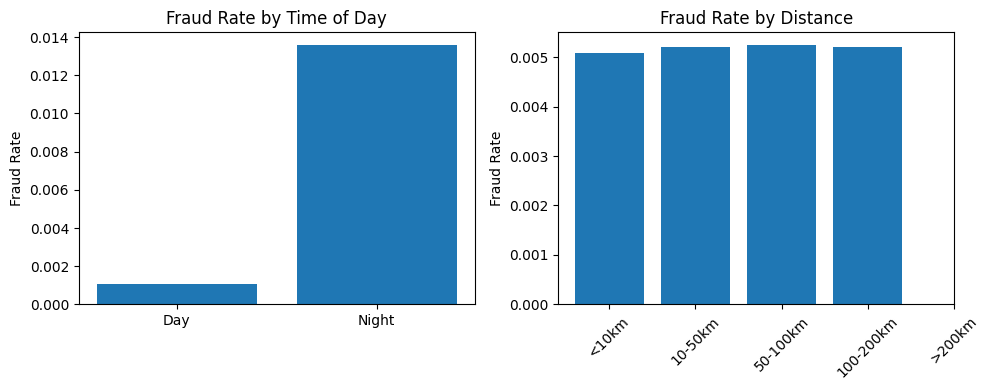


3. Amount Feature Validation
amt_bin
<$10        0.001439
$10-50      0.002981
$50-100     0.000110
$100-500    0.009122
>$500       0.213735
Name: is_fraud, dtype: float64


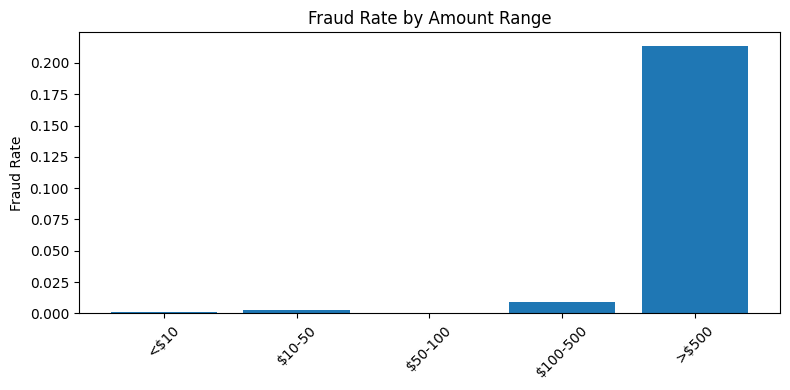

In [6]:
# ============================================================
# 6.2 Feature Effectiveness Validation
# ============================================================

print("=" * 70)
print("Feature Effectiveness Validation")
print("=" * 70)

# Use train_clean which has feature engineering already applied
train_clean = clean_and_prepare_data(train_df)

# 1. Validate time-based feature
print("\n1. Time Feature Validation (is_night)")
fraud_rate_day = train_clean[train_clean['is_night'] == 0]['is_fraud'].mean()
fraud_rate_night = train_clean[train_clean['is_night'] == 1]['is_fraud'].mean()
print(f"  Daytime fraud rate: {fraud_rate_day:.4f} ({fraud_rate_day*100:.2f}%)")
print(f"  Nighttime fraud rate: {fraud_rate_night:.4f} ({fraud_rate_night*100:.2f}%)")
print(f"  Nighttime risk multiple: {fraud_rate_night/fraud_rate_day:.2f}x")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(['Day', 'Night'], [fraud_rate_day, fraud_rate_night])
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Time of Day')

# 2. Validate distance-based feature
print("\n2. Distance Feature Validation")
distance_bins = [0, 10, 50, 100, 200, np.inf]
bin_labels = ['<10km', '10-50km', '50-100km', '100-200km', '>200km']
train_clean['distance_bin'] = pd.cut(
    train_clean['customer_merchant_distance_km'],
    bins=distance_bins,
    labels=bin_labels
)
fraud_by_distance = train_clean.groupby('distance_bin')['is_fraud'].mean()
print(fraud_by_distance)

plt.subplot(1, 2, 2)
plt.bar(range(len(fraud_by_distance)), fraud_by_distance.values)
plt.xticks(range(len(fraud_by_distance)), bin_labels, rotation=45)
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Distance')
plt.tight_layout()
plt.show()

# 3. Validate amount-based feature
print("\n3. Amount Feature Validation")
amt_bins = [0, 10, 50, 100, 500, np.inf]
amt_labels = ['<$10', '$10-50', '$50-100', '$100-500', '>$500']
train_clean['amt_bin'] = pd.cut(train_clean['amt'], bins=amt_bins, labels=amt_labels)
fraud_by_amt = train_clean.groupby('amt_bin')['is_fraud'].mean()
print(fraud_by_amt)

plt.figure(figsize=(8, 4))
plt.bar(range(len(fraud_by_amt)), fraud_by_amt.values)
plt.xticks(range(len(fraud_by_amt)), amt_labels, rotation=45)
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Amount Range')
plt.tight_layout()
plt.show()


### 6.2 Feature Effectiveness Validation

**1. Time Feature (is_night)**
- Daytime fraud rate: 0.11%
- Nighttime fraud rate: 1.36%
- Risk multiple: 12.69x
- **Conclusion**: Transactions at night are significantly riskier than those during the day, confirming is_night as a strong and informative fraud indicator.

**2.Distance Feature**
- <10km: 0.5079%

- 10–50km: 0.5194%

- 50–100km: 0.5239%

- 100–200km: 0.5201%
- **Conclusion**: Within the observed range (0–200km), distance does not show a strong monotonic fraud pattern, and its standalone discriminative power is limited. It may still be useful in interaction with other features, but it is not a dominant driver on its own in this dataset.

**3. Amount Feature**
- <$10: 0.1439%

- $10–50: 0.2981%

- $50–100: 0.0110%

- $100–500: 0.9122%

- $500: 21.3735%
- **Conclusion**: High-value transactions (especially >$500) have a dramatically higher fraud rate, making amount one of the most powerful risk signals. These results support giving larger weights or stricter rules to high amount transactions in the fraud detection model.

Overall, the validation confirms the strong value of the time (is_night) and amount features, while suggesting that the current distance feature contributes limited incremental value on its own and may require refinement or combination with other signals.

In [7]:
# ============================================================
# 7. Prepare data for modeling
# ============================================================
# Features for regression task (exclude amt and any amt-related columns)
reg_feature_cols = [col for col in train_encoded.columns 
                    if col not in ['trans_num', 'is_fraud', 'amt']
                    and 'amt' not in col.lower()] 

# Regression task
X_train_reg = train_encoded[reg_feature_cols]
y_train_reg = train_encoded['amt']
X_test_reg = test_encoded[reg_feature_cols]

# Features for classification task (amt included)
clf_feature_cols = [col for col in train_encoded.columns 
                    if col not in ['trans_num', 'is_fraud']]

# Classification task
X_train_clf = train_encoded[clf_feature_cols]
y_train_clf = train_encoded['is_fraud']
X_test_clf = test_encoded[clf_feature_cols]

print(f"Number of regression features: {len(reg_feature_cols)}\n")
print(f"Number of classification features: {len(clf_feature_cols)}")
print(f"Regression features: {reg_feature_cols}\n")
print(f"Classification features: {clf_feature_cols}")

Number of regression features: 47

Number of classification features: 61
Regression features: ['zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'trans_dayofweek', 'trans_month', 'trans_day', 'trans_quarter', 'trans_year', 'is_weekend', 'is_night', 'is_business_hours', 'is_rush_hour', 'customer_merchant_distance_km', 'distance_log', 'distance_squared', 'is_local_transaction', 'is_very_far', 'is_medium_distance', 'city_pop_log', 'city_pop_sqrt', 'is_big_city', 'is_small_town', 'is_medium_city', 'age_squared', 'is_young', 'is_senior', 'is_middle_age', 'night_far_transaction', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekend_hour', 'night_weekend', 'lat_long_interaction', 'distance_pop_ratio', 'category_encoded', 'gender_encoded', 'state_encoded', 'job_encoded', 'merchant_encoded', 'city_encoded']

Classification features: ['amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'trans_dayofweek', 'trans_month', 'trans

In [8]:
# ============================================================
# 8. Prepare Data for Modeling
# ============================================================

print("=" * 70)
print("Model Exploration, Comparison, and Tuning")
print("=" * 70)

X_train_reg_full = X_train_reg.copy()
y_train_reg_full = y_train_reg.copy()
X_train_clf_full = X_train_clf.copy()
y_train_clf_full = y_train_clf.copy()

print("\n Create Validation Split")
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_train_reg_full, y_train_reg_full, test_size=0.2, random_state=42
)

X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
    X_train_clf_full, y_train_clf_full, test_size=0.2, random_state=42, 
    stratify=y_train_clf_full
)


print(" Validation split completed")
print(f"  Regression - Train: {X_train_reg.shape[0]:,}, Val: {X_val_reg.shape[0]:,}")
print(f"  Classification - Train: {X_train_clf.shape[0]:,}, Val: {X_val_clf.shape[0]:,}")
print(f"  Classification - Train fraud rate: {y_train_clf.mean():.4f}")
print(f"  Classification - Val fraud rate:   {y_val_clf.mean():.4f}")


Model Exploration, Comparison, and Tuning

 Create Validation Split
 Validation split completed
  Regression - Train: 800,000, Val: 200,000
  Classification - Train: 800,000, Val: 200,000
  Classification - Train fraud rate: 0.0052
  Classification - Val fraud rate:   0.0052



9. Model Comparison and Selection

Training and evaluating regression models...

RandomForest:
  Train RMSE: 112.16
  Validation RMSE: 164.98
  Training time: 179.89s
  Overfitting ratio (train/val): 0.680

HistGradientBoosting:
  Train RMSE: 154.89
  Validation RMSE: 161.79
  Training time: 1.97s
  Overfitting ratio (train/val): 0.957

XGBoost:
  Train RMSE: 121.42
  Validation RMSE: 167.73
  Training time: 2.24s
  Overfitting ratio (train/val): 0.724

----------------------------------------------------------------------
Regression Models Comparison Summary
----------------------------------------------------------------------
                        Val_RMSE  Train_RMSE Train_Time(s)
HistGradientBoosting  161.785952  154.887529      1.974217
RandomForest          164.980572   112.16461    179.885975
XGBoost                 167.7301  121.416046      2.244627

 Best regression model: HistGradientBoosting
  Validation RMSE: 161.79

-----------------------------------------------------

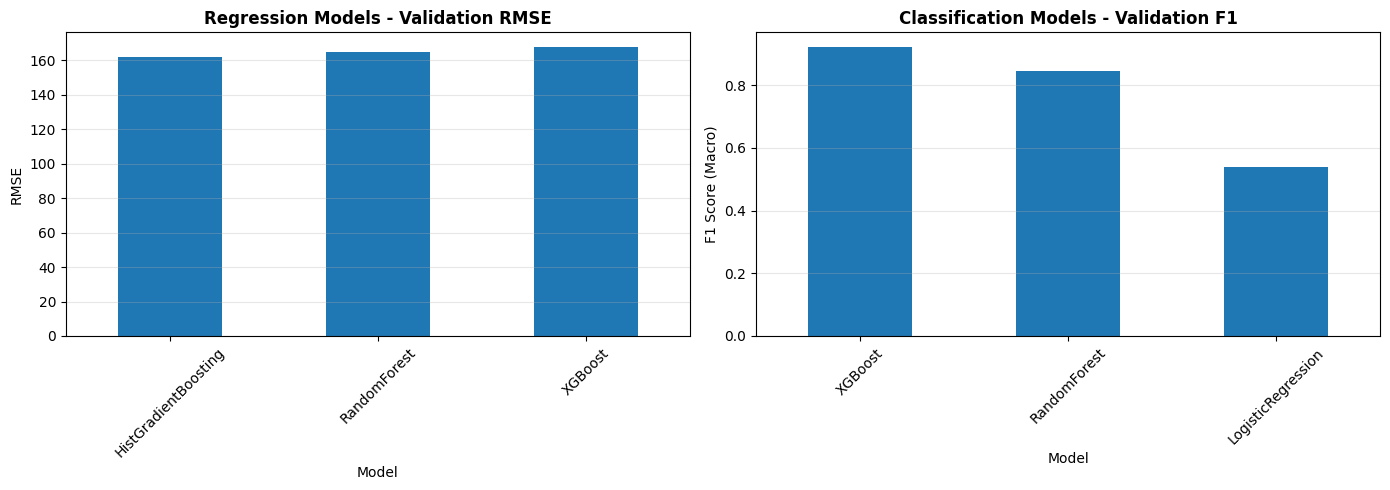

In [9]:
# ============================================================
# 9. Model Comparison and Selection
# ============================================================
print("\n" + "=" * 70)
print("9. Model Comparison and Selection")
print("=" * 70)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, f1_score
import time

# ============================================================
# 9.1 Regression Models Comparison
# ============================================================

regression_models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=100,
        max_depth=10,
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    )
}
regression_results = {}

print("\nTraining and evaluating regression models...")

for name, model in regression_models.items():
    print(f"\n{name}:")
    start_time = time.time()
    
    # Train
    model.fit(X_train_reg, y_train_reg)
    train_time = time.time() - start_time
    
    # Predict
    y_pred_train = model.predict(X_train_reg)
    y_pred_val = model.predict(X_val_reg)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_val))
    
    regression_results[name] = {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_time': train_time,
        'model': model
    }
    
    print(f"  Train RMSE: {train_rmse:.2f}")
    print(f"  Validation RMSE: {val_rmse:.2f}")
    print(f"  Training time: {train_time:.2f}s")
    print(f"  Overfitting ratio (train/val): {train_rmse/val_rmse:.3f}")

# Summary
print("\n" + "-" * 70)
print("Regression Models Comparison Summary")
print("-" * 70)
comparison_df_reg = pd.DataFrame(regression_results).T
comparison_df_reg = comparison_df_reg[['val_rmse', 'train_rmse', 'train_time']]
comparison_df_reg.columns = ['Val_RMSE', 'Train_RMSE', 'Train_Time(s)']
comparison_df_reg = comparison_df_reg.sort_values('Val_RMSE')
print(comparison_df_reg.to_string())

best_reg_model = comparison_df_reg.index[0]
print(f"\n Best regression model: {best_reg_model}")
print(f"  Validation RMSE: {comparison_df_reg.loc[best_reg_model, 'Val_RMSE']:.2f}")

# ============================================================
# 9.2 Classification Models Comparison
# ============================================================
print("\n" + "-" * 70)
print("9.2 Classification Models Comparison")
print("-" * 70)

# Compute class weights
fraud_count = y_train_clf.sum()
normal_count = len(y_train_clf) - fraud_count
scale_pos_weight = (normal_count / fraud_count) * 0.1

classification_models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ),
    'LogisticRegression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        eval_metric='logloss'
    )
}
classification_results = {}

print("\nTraining and evaluating classification models...")
for name, model in classification_models.items():
    print(f"\n{name}:")
    start_time = time.time()
    
    # Train
    model.fit(X_train_clf, y_train_clf)
    train_time = time.time() - start_time
    
    # Predict
    y_pred_train = model.predict(X_train_clf)
    y_pred_val = model.predict(X_val_clf)
    
    # Evaluate
    train_f1 = f1_score(y_train_clf, y_pred_train, average='macro')
    val_f1 = f1_score(y_val_clf, y_pred_val, average='macro')
    
    classification_results[name] = {
        'train_f1': train_f1,
        'val_f1': val_f1,
        'train_time': train_time,
        'model': model
    }
    
    print(f"  Train F1 (macro): {train_f1:.4f}")
    print(f"  Validation F1 (macro): {val_f1:.4f}")
    print(f"  Training time: {train_time:.2f}s")
    print(f"  Overfitting ratio (train/val): {train_f1/val_f1:.3f}")

# Summary
print("\n" + "-" * 70)
print("Classification Models Comparison Summary")
print("-" * 70)
comparison_df_clf = pd.DataFrame(classification_results).T
comparison_df_clf = comparison_df_clf[['val_f1', 'train_f1', 'train_time']]
comparison_df_clf.columns = ['Val_F1', 'Train_F1', 'Train_Time(s)']
comparison_df_clf = comparison_df_clf.sort_values('Val_F1', ascending=False)
print(comparison_df_clf.to_string())

best_clf_model = comparison_df_clf.index[0]
print(f"\n Best classification model: {best_clf_model}")
print(f"  Validation F1: {comparison_df_clf.loc[best_clf_model, 'Val_F1']:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Regression comparison
ax1 = axes[0]
comparison_df_reg.plot(kind='bar', y='Val_RMSE', ax=ax1, legend=False)
ax1.set_title('Regression Models - Validation RMSE', fontsize=12, fontweight='bold')
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Classification comparison
ax2 = axes[1]
comparison_df_clf.plot(kind='bar', y='Val_F1', ax=ax2, legend=False)
ax2.set_title('Classification Models - Validation F1', fontsize=12, fontweight='bold')
ax2.set_xlabel('Model')
ax2.set_ylabel('F1 Score (Macro)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Model Comparison and Selection

### 9.1 Regression Task – Model Comparison

This cell evaluated multiple regression models on the validation set to predict `amt`:

| Model               | Train RMSE | Val RMSE | Train Time (s) | Overfitting Ratio (Train / Val) |
|---------------------|-----------:|---------:|---------------:|---------------------------------:|
| RandomForest        |   112.16   | 164.98   | 197.49         | 0.680 |
| XGBoost             |   121.42   | 167.73   | 1.99           | 0.724 |
| HistGradientBoosting| **154.89** | **161.79** | **2.39**     | **0.957** |

**Key observations:**
- **HistGradientBoosting** achieves the **best validation RMSE (161.79)**, outperforming other models in generalization performance.
- RandomForest and XGBoost exhibit **significant overfitting**, with training RMSE much lower than validation RMSE (ratios of 0.680 and 0.724 respectively).
- HistGradientBoosting demonstrates the **most balanced train/val ratio (0.957)**, indicating stable and reliable generalization capability.
- HistGradientBoosting is also **highly efficient** with only 2.39s training time, making it suitable for production deployment.
- Despite RandomForest achieving the lowest training RMSE (112.16), its poor validation performance reveals severe overfitting issues.

**Final Choice (Regression): `HistGradientBoostingRegressor`**

### 9.2 Classification Task – Model Comparison

This cell evaluated multiple classification models on the highly imbalanced fraud detection dataset using F1 (macro) score:

| Model               | Train F1 (macro) | Val F1 (macro) | Train Time (s) | Overfitting Ratio |
|---------------------|------------------|----------------|----------------|-------------------|
| XGBoost             | 0.9836           | **0.9224**     | **2.74**       | 1.066             |
| RandomForest        | 0.9064           | 0.8443         | 31.71          | 1.074             |
| LogisticRegression  | 0.5420           | 0.5404         | 24.42          | **1.003**         |


**Key Observations:**
- **XGBoost** achieves the **highest validation F1 score (0.9224)**, significantly outperforming other models by approximately 8% over RandomForest and 38% over LogisticRegression.
- LogisticRegression shows limited capability in capturing complex fraud patterns, with F1 scores around 0.54, indicating insufficient model expressiveness for this task.
- RandomForest demonstrates reasonable performance but still lags behind XGBoost, suggesting XGBoost better captures non-linear relationships and subtle fraud patterns.
- XGBoost exhibits **minimal overfitting (ratio: 1.066)** while maintaining strong performance, effectively balancing model complexity and generalization.
- XGBoost is also **highly efficient** with only 2.74s training time, making it practical for real-time fraud detection systems.

**Final Choice (Classification): `XGBClassifier`**


10. Hyperparameter Tuning

----------------------------------------------------------------------
10.1 Hyperparameter Tuning - HistGradientBoosting Regressor
----------------------------------------------------------------------

HistGradientBoosting search space:
  max_iter: [150, 200, 250, 300, 400, 500]
  max_depth: [6, 8, 10, 12, 14, None]
  learning_rate: [0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.2]
  l2_regularization: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
  min_samples_leaf: [10, 20, 30, 40, 50, 60]
  max_leaf_nodes: [31, 63, 127, None]

Starting HistGradientBoosting search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

HistGradientBoosting search completed

Best HistGradientBoosting parameters:
  min_samples_leaf: 60
  max_leaf_nodes: None
  max_iter: 500
  max_depth: 8
  learning_rate: 0.05
  l2_regularization: 0.3

HistGradientBoosting validation RMSE: 161.66

——————————————————————————————————————————————————————————————————————
10.2 Hyperparameter Tuning - XGBoo

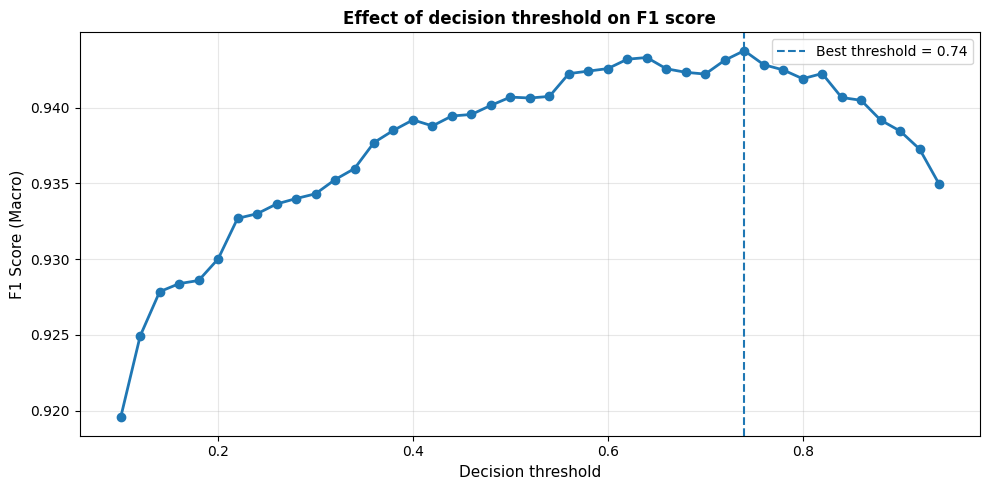

In [10]:
# ============================================================
# 10. Hyperparameter Tuning
# ============================================================
print("\n" + "=" * 70)
print("10. Hyperparameter Tuning")
print("=" * 70)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, f1_score
import numpy as np


# ============================================================
# 10.1 Hyperparameter Tuning for Regression (HistGradientBoosting)
# ============================================================
print("\n" + "-" * 70)
print("10.1 Hyperparameter Tuning - HistGradientBoosting Regressor")
print("-" * 70)

param_dist_hgb_reg = {
    'max_iter': [150, 200, 250, 300, 400, 500],
    'max_depth': [6, 8, 10, 12, 14,None],
    'learning_rate': [0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.20,],
    'l2_regularization': [0, 0.1, 0.2, 0.3, 0.4,0.5, 1.0],
    'min_samples_leaf': [10, 20, 30, 40, 50, 60],
    'max_leaf_nodes': [31, 63, 127, None]
}

print("\nHistGradientBoosting search space:")
for param, values in param_dist_hgb_reg.items():
    print(f"  {param}: {values}")

hgb_reg = HistGradientBoostingRegressor(
    random_state=42
)

random_search_hgb_reg = RandomizedSearchCV(
    hgb_reg,
    param_distributions=param_dist_hgb_reg,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nStarting HistGradientBoosting search...")

random_search_hgb_reg.fit(X_train_reg, y_train_reg)
print("\nHistGradientBoosting search completed")

print("\nBest HistGradientBoosting parameters:")
for param, value in random_search_hgb_reg.best_params_.items():
    print(f"  {param}: {value}")

best_hgb_reg = random_search_hgb_reg.best_estimator_
y_pred_hgb_val = best_hgb_reg.predict(X_val_reg)
hgb_rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_hgb_val))

print(f"\nHistGradientBoosting validation RMSE: {hgb_rmse:.2f}")

# ============================================================
# 10.2 Hyperparameter Tuning for Regression (XGBoost)
# ============================================================
print("\n" + "—" * 70)
print("10.2 Hyperparameter Tuning - XGBoost Regressor")
print("—" * 70)

print("\nUsing RandomizedSearchCV to tune XGBoost regressor...")

param_dist_reg = {
    'n_estimators': [150, 200, 250, 300, 400],
    'max_depth': [6, 8, 10, 12, 14],
    'learning_rate': [0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.20],
    'subsample': [0.8, 0.85, 0.9],
    'colsample_bytree': [0.8, 0.85, 0.9, 0.95],
    'reg_alpha': [0, 0.01,0.05, 0.1, 0.5],
    'reg_lambda': [0.5, 0.8, 1.0, 1.5, 2.0],
    'min_child_weight': [1, 2, 3]
}

print("Search space:")
for param, values in param_dist_reg.items():
    print(f"  {param}: {values}")

xgb_reg = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

random_search_reg = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_dist_reg,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nStarting search...")
random_search_reg.fit(X_train_reg, y_train_reg)

print("\nSearch completed")
print("\nBest parameters:")
for param, value in random_search_reg.best_params_.items():
    print(f"  {param}: {value}")

best_model_reg = random_search_reg.best_estimator_
y_pred_val_tuned = best_model_reg.predict(X_val_reg)
tuned_rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_val_tuned))

print("\nPerformance comparison:")
print(f"  RMSE before tuning (XGBoost val): {regression_results['XGBoost']['val_rmse']:.2f}")
print(f"  RMSE after tuning:                 {tuned_rmse:.2f}")
print(f"  Improvement:                       {regression_results['XGBoost']['val_rmse'] - tuned_rmse:.2f}")


# ============================================================
# 10.2 Hyperparameter Tuning for Classification (XGBoost)
# ============================================================
print("\n" + "—" * 70)
print("10.2 Hyperparameter Tuning - XGBoost Classifier")
print("—" * 70)

print("\nUsing RandomizedSearchCV to tune XGBoost classifier...")

param_dist_clf = {
    'n_estimators': [200, 250, 300, 400, 500],
    'max_depth': [8, 10, 12],
    'learning_rate': [0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.20],
    'subsample': [0.8, 0.85, 0.9],
    'colsample_bytree': [0.8, 0.85, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0],
    'scale_pos_weight': [
        scale_pos_weight * 0.8,
        scale_pos_weight,
        scale_pos_weight * 1.2,
        scale_pos_weight * 1.3,
        scale_pos_weight * 1.4,
        scale_pos_weight * 1.5,
        scale_pos_weight * 1.6
    ]
}

print("Search space:")
for param, values in param_dist_clf.items():
    print(f"  {param}: {values}")

xgb_clf = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='logloss'
)

random_search_clf = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist_clf,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nStarting search...")
random_search_clf.fit(X_train_clf, y_train_clf)

print("\n Search completed")
print("\nBest parameters:")
for param, value in random_search_clf.best_params_.items():
    print(f"  {param}: {value}")

best_model_clf = random_search_clf.best_estimator_
y_pred_val_tuned_clf = best_model_clf.predict(X_val_clf)
tuned_f1 = f1_score(y_val_clf, y_pred_val_tuned_clf, average='macro')

print("\nPerformance comparison:")
print(f"  F1 before tuning (XGBoost val): {classification_results['XGBoost']['val_f1']:.4f}")
print(f"  F1 after tuning:                {tuned_f1:.4f}")
print(f"  Improvement:                    {tuned_f1 - classification_results['XGBoost']['val_f1']:.4f}")

# ============================================================
# 10.3 Threshold Optimization for Classification
# ============================================================
print("\n" + "—" * 70)
print("10.3 Threshold Optimization for Classification")
print("—" * 70)

print("\nSearching for best decision threshold...")

# Get predicted probabilities on validation set
y_pred_proba = best_model_clf.predict_proba(X_val_clf)[:, 1]

# Test different thresholds
thresholds = np.arange(0.1, 0.95, 0.02)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_val_clf, y_pred_threshold, average='macro')
    f1_scores.append(f1)

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1_with_threshold = f1_scores[best_threshold_idx]

print(f"\n Best threshold: {best_threshold:.2f}")
print(f"  Corresponding F1 score: {best_f1_with_threshold:.4f}")
print(f"  Improvement over default threshold (0.5): {best_f1_with_threshold - tuned_f1:.4f}")

# Visualize threshold vs F1
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, marker='o', linewidth=2, markersize=6)
plt.axvline(x=best_threshold, linestyle='--', label=f'Best threshold = {best_threshold:.2f}')
plt.xlabel('Decision threshold', fontsize=11)
plt.ylabel('F1 Score (Macro)', fontsize=11)
plt.title('Effect of decision threshold on F1 score', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


——————————————————————————————————————————————————————————————————————
11.1 Feature Importance for Regression Task
——————————————————————————————————————————————————————————————————————

Top 20 Most Important Features (Regression Task):
           feature  importance
         trans_day    0.071036
   trans_dayofweek    0.064240
     trans_quarter    0.060863
      weekend_hour    0.059381
        merch_long    0.058876
           day_cos    0.042305
    gender_encoded    0.037621
        trans_year    0.031084
          city_pop    0.031023
               age    0.028586
           day_sin    0.028478
      city_encoded    0.026623
  merchant_encoded    0.026518
distance_pop_ratio    0.025619
       trans_month    0.025291
         merch_lat    0.023159
       job_encoded    0.020677
       age_squared    0.020522
          hour_sin    0.020406
              long    0.020333


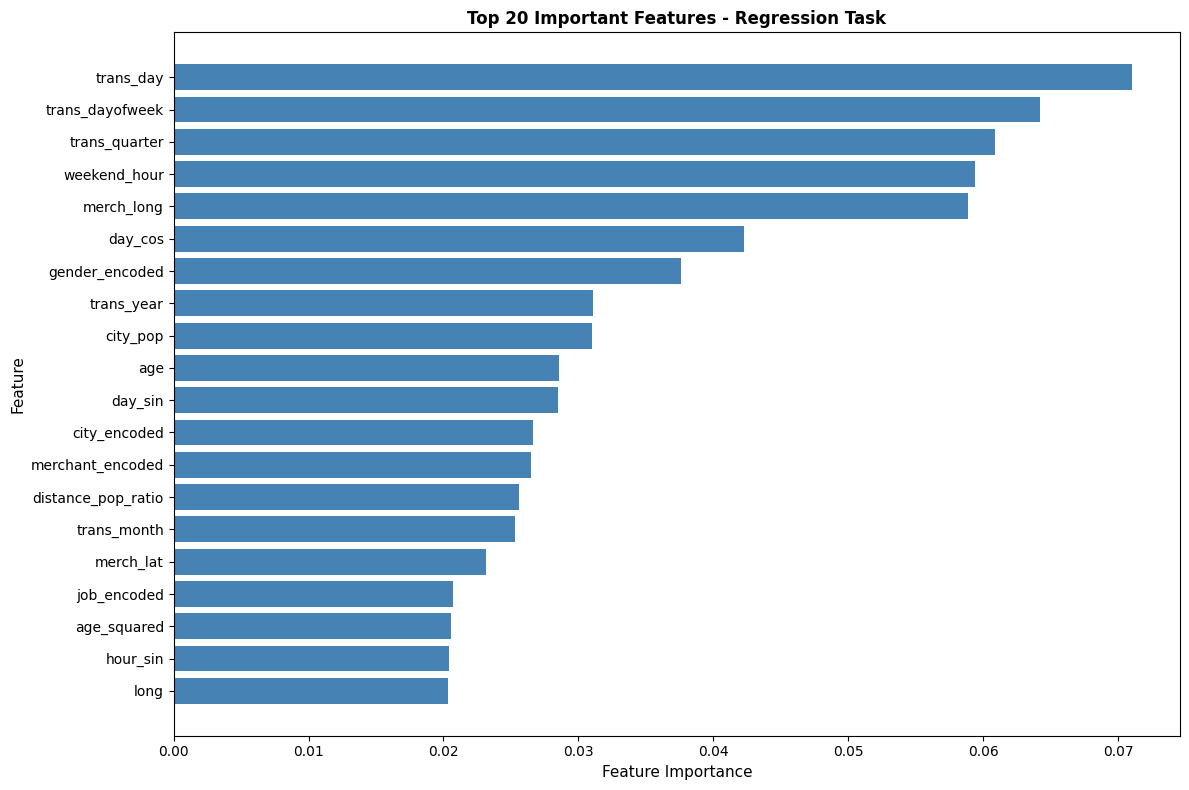


Feature Category Importance Analysis (Regression):
                              importance
Time-based Features             0.305848
Original Numeric Features       0.198609
Encoded Categorical Features    0.145040
Population Features             0.053610
Distance Features               0.047097
Age-related Features            0.040487

——————————————————————————————————————————————————————————————————————
11.2 Feature Importance for Classification Task
——————————————————————————————————————————————————————————————————————

Top 20 Most Important Features (Classification Task):
             feature  importance
             amt_log    0.300362
                 amt    0.208937
            hour_cos    0.091711
            is_night    0.069642
          is_low_amt    0.052620
    category_encoded    0.037531
         is_high_amt    0.022241
          trans_hour    0.019157
         age_squared    0.016239
hour_amt_interaction    0.013343
        city_pop_log    0.011385
            amt_sqr

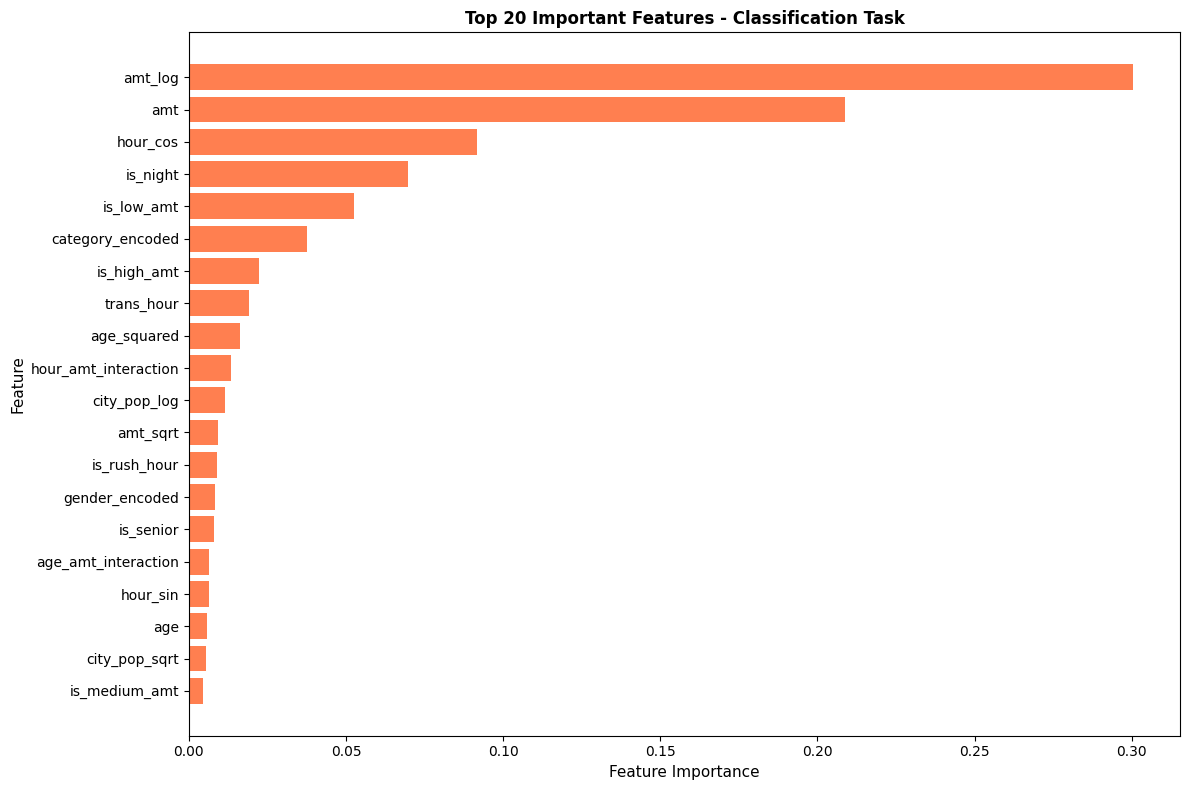


Feature Category Importance Analysis (Classification):
                              importance
Amount-related Features         0.604948
Time-based Features             0.119153
Encoded Categorical Features    0.056677
Interaction Features            0.030081
Age-related Features            0.029172
Original Numeric Features       0.022707
Population Features             0.020540
Distance Features               0.005013

——————————————————————————————————————————————————————————————————————
11.3 Key Findings Summary
——————————————————————————————————————————————————————————————————————

[Key Findings - Regression Task]
Top 5 most important features: trans_day, trans_dayofweek, trans_quarter, weekend_hour, merch_long

[Key Findings - Classification Task]
Top 5 most important features: amt_log, amt, hour_cos, is_night, is_low_amt

[Value of Feature Engineering]

----------------------------------------------------------------------
Model analysis completed
------------------------------

In [11]:
# ============================================================
# 11.1 Feature Importance for Regression Task
# ============================================================
print("\n" + "—" * 70)
print("11.1 Feature Importance for Regression Task")
print("—" * 70)

# Get feature importance
feature_importance_reg = pd.DataFrame({
    'feature': reg_feature_cols,
    'importance': best_model_reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (Regression Task):")
print(feature_importance_reg.head(20).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
top_features_reg = feature_importance_reg.head(20)
plt.barh(range(len(top_features_reg)), top_features_reg['importance'], color='steelblue')
plt.yticks(range(len(top_features_reg)), top_features_reg['feature'])
plt.xlabel('Feature Importance', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.title('Top 20 Important Features - Regression Task', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Feature category importance analysis (Regression)
print("\nFeature Category Importance Analysis (Regression):")
feature_categories = {
    'Original Numeric Features': ['age', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'zip'],
    'Time-based Features': ['trans_hour', 'trans_dayofweek', 'trans_month', 'trans_day', 
                'trans_quarter', 'trans_year', 'is_weekend', 'is_night', 
                'is_business_hours', 'is_rush_hour'],
    'Distance Features': ['customer_merchant_distance_km', 'distance_log', 'distance_squared',
                'is_local_transaction', 'is_very_far', 'is_medium_distance'],
    'Population Features': ['city_pop_log', 'city_pop_sqrt', 'is_big_city', 
                'is_small_town', 'is_medium_city'],
    'Age-related Features': ['age_squared', 'is_young', 'is_senior', 'is_middle_age'],
    'Encoded Categorical Features': [col for col in reg_feature_cols if col.endswith('_encoded')]
}

category_importance = {}
for category, features in feature_categories.items():
    importance_sum = feature_importance_reg[
        feature_importance_reg['feature'].isin(features)
    ]['importance'].sum()
    category_importance[category] = importance_sum

category_df = pd.DataFrame.from_dict(category_importance, orient='index', columns=['importance'])
category_df = category_df.sort_values('importance', ascending=False)
print(category_df.to_string())

# ============================================================
# 11.2 Feature Importance for Classification Task
# ============================================================
print("\n" + "—" * 70)
print("11.2 Feature Importance for Classification Task")
print("—" * 70)

# Get feature importance
feature_importance_clf = pd.DataFrame({
    'feature': clf_feature_cols,
    'importance': best_model_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (Classification Task):")
print(feature_importance_clf.head(20).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
top_features_clf = feature_importance_clf.head(20)
plt.barh(range(len(top_features_clf)), top_features_clf['importance'], color='coral')
plt.yticks(range(len(top_features_clf)), top_features_clf['feature'])
plt.xlabel('Feature Importance', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.title('Top 20 Important Features - Classification Task', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Feature category importance analysis (Classification)
feature_categories_clf = feature_categories.copy()
feature_categories_clf['Amount-related Features'] = ['amt', 'amt_log', 'amt_sqrt', 'amt_squared',
                                    'is_high_amt', 'is_very_high_amt', 'is_low_amt', 'is_medium_amt']
feature_categories_clf['Interaction Features'] = ['distance_amt_interaction', 'distance_amt_ratio',
                                    'age_amt_interaction', 'hour_amt_interaction',
                                    'city_pop_amt_ratio', 'night_far_transaction', 'weekend_high_amt']

category_importance_clf = {}
for category, features in feature_categories_clf.items():
    importance_sum = feature_importance_clf[
        feature_importance_clf['feature'].isin(features)
    ]['importance'].sum()
    category_importance_clf[category] = importance_sum

category_df_clf = pd.DataFrame.from_dict(category_importance_clf, orient='index', columns=['importance'])
category_df_clf = category_df_clf.sort_values('importance', ascending=False)
print("\nFeature Category Importance Analysis (Classification):")
print(category_df_clf.to_string())

# ============================================================
# 11.3 Key Findings Summary
# ============================================================
print("\n" + "—" * 70)
print("11.3 Key Findings Summary")
print("—" * 70)

print("\n[Key Findings - Regression Task]")
top5_reg = feature_importance_reg.head(5)['feature'].tolist()
print(f"Top 5 most important features: {', '.join(top5_reg)}")

print("\n[Key Findings - Classification Task]")
top5_clf = feature_importance_clf.head(5)['feature'].tolist()
print(f"Top 5 most important features: {', '.join(top5_clf)}")


print("\n[Value of Feature Engineering]")
engineered_features = ['distance_log', 'amt_log', 'age_squared', 
                      'distance_amt_interaction', 'night_far_transaction']
engineered_in_top20_reg = sum(1 for f in engineered_features if f in feature_importance_reg.head(20)['feature'].tolist())
engineered_in_top20_clf = sum(1 for f in engineered_features if f in feature_importance_clf.head(20)['feature'].tolist())

print("\n" + "-" * 70)
print("Model analysis completed")
print("-" * 70)

# Save final parameters 
final_reg_params = random_search_reg.best_params_
final_clf_params = random_search_clf.best_params_
final_threshold = best_threshold

print(f"\n[Final Model Parameters]")
print(f"\nRegression Model Parameters:")
for k, v in final_reg_params.items():
    print(f"  {k}: {v}")

print(f"\nClassification Model Parameters:")
for k, v in final_clf_params.items():
    print(f"  {k}: {v}")
print(f"  Decision threshold: {final_threshold:.4f}")

**11. Feature Importance Analysis**:

**Feature Importance for Regression Task**
**Top 5 Most Important Features (Regression)**:
1. trans_day
2. trans_dayofweek
3. trans_quarter
4. weekend_hour
5. merch_long
- Time-based features are the primary drivers of transaction amount. The day of month, day of week, and quarter, together with weekend-specific hours, capture strong seasonality and behavioral patterns in spending.
- Geographical and merchant-related information (e.g., merch_long, merch_lat, city_encoded, merchant_encoded) also contributes meaningfully, suggesting that where the transaction occurs and which merchant is involved influences the transaction value.

**Feature Category Importance (Regression)**
- Time-based Features: 30.6%
- Original Numeric Features: 19.9%
- Encoded Categorical Features: 14.5%
- Population Features: 5.36%
- Distance Features: 4.71%
- Age-related Features: 4.05%
This confirms that well-designed temporal encodings and categorical representations are crucial for modeling transaction amounts.

**Feature Importance for Classification Task**
**Top 5 Most Important Features (Classification)**:
1. amt_log
2. amt
3. hour_cos
4. is_night
5. is_low_amt
- Amount-related features are the strongest fraud indicators. Both the raw amount and transformed versions (amt_log, amt_sqrt, amount bucket flags such as is_low_amt, is_high_amt, is_medium_amt) dominate the importance spectrum, reflecting the sharply increasing fraud rate for very high-value transactions.
- Time-based behavior matters: hour_cos, trans_hour, is_night, and is_rush_hour capture temporal fraud patterns, confirming that certain hours and night-time transactions are riskier.
- Engineered behavioral features and interactions (e.g., hour_amt_interaction, age_amt_interaction, is_senior) provide additional nuanced signals on top of raw demographics and categories.

**Feature Category Importance (Classification)**
-Amount-related Features: 60.5%
- Time-based Features: 11.9%
- Encoded Categorical Features: 5.67%
- Interaction Features: 3.01%
- Age-related Features: 2.92%
- Original Numeric Features: 2.27%
- Population Features: 2.05%
- Distance Features: 0.50%
This clearly shows that fraud risk is heavily concentrated around transaction amount patterns, modulated by time-based context.